In [1]:
# Import all necessary libraries and utility functions
import math
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# Import dataset to be used for training and testing
AAPL = pd.read_csv("./Database/Pre_Processed_AAPL.csv")
AMZN = pd.read_csv("./Database/Pre_Processed_AMZN.csv")
GOOG = pd.read_csv("./Database/Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("./Database/Pre_Processed_MSFT.csv")
TSLA = pd.read_csv("./Database/Pre_Processed_TSLA.csv")

### Data Preprocessing

In [3]:
# Shape the data to for use with LightGBM
def prep_data(data, split_date):
    data['Date'] = pd.to_datetime(data['Date'])

    # Introduce lag featues into the dataset (5 days lag)
    for lag in range(1, 91):
        data[f'lag_{lag}'] = data['Adj. Close'].shift(lag)

    # Bollinger Bands
    # window =20
    # rolling_mean = data['Adj. Close'].rolling(window=window).mean()
    # rolling_std = data['Adj. Close'].rolling(window=window).std()
    # multiplier = 2
    # data['bb_upper'] = rolling_mean + (rolling_std * multiplier)
    # data['bb_middle'] = rolling_mean
    # data['bb_lower'] = rolling_mean - (rolling_std * multiplier)

    # MACD
    def ema(series, span):
        return series.ewm(span=span, adjust=False).mean()
        
    data['ema_fast'] = ema(data['Adj. Close'], 12)
    data['ema_slow'] = ema(data['Adj. Close'], 26)
    data['macd'] = data['ema_fast'] - data['ema_slow']
    data['macd_signal'] = ema(data['macd'], 9)
    data['macd_diff'] = data['macd'] - data['macd_signal']

    # Moving Averages
    data['ma_5'] = data['Adj. Close'].rolling(30).mean()
    data['ma_10'] = data['Adj. Close'].rolling(60).mean()
    data['ma_10'] = data['Adj. Close'].rolling(90).mean()
    data['ma_10'] = data['Adj. Close'].rolling(120).mean()
    data['ma_10'] = data['Adj. Close'].rolling(150).mean()
    data['ma_10'] = data['Adj. Close'].rolling(180).mean()
    data['ma_10'] = data['Adj. Close'].rolling(210).mean()
    
    # Momentum features
    # data['momentum_5'] = data['Adj. Close'] - data['Adj. Close'].shift(5)
    # data['momentum_10'] = data['Adj. Close'] - data['Adj. Close'].shift(10)

    # EMA
    # data['ema_5'] = data['Adj. Close'].ewm(span=5, adjust=False).mean()
    # data['ema_20'] = data['Adj. Close'].ewm(span=20, adjust=False).mean()
    # data['ema_50'] = data['Adj. Close'].ewm(span=50, adjust=False).mean()

    # Add volume-based features
    # data['vol_ma_5'] = data['Volume'].rolling(5).mean()
    # data['vol_ma_10'] = data['Volume'].rolling(10).mean()
    # data['vpt'] = (data['Volume'] * (data['Adj. Close'].pct_change())).cumsum()

    # RSI
    delta = data['Adj. Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    window = 14
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    data['rsi'] = 100 - (100 / (1 + rs))
    
    # Stochastic Oscillator
    lowest_low = data['Low'].rolling(window=14).min()
    highest_high = data['High'].rolling(window=14).max()
    data['stoch_k'] = ((data['Adj. Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    data['stoch_d'] = data['stoch_k'].rolling(3).mean()

    # Meta Sine Wave
    data['meta_sine_wave'] = np.sin(data['Adj. Close'].pct_change().cumsum())

    # Drop rows with NaN values introduced my lagging
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    train_data = data[data['Date'] < split_date]
    test_data = data[data['Date'] >= split_date]

    features = [col for col in data.columns if col not in ['Date', 'Adj. Close', 'target']]
    # features = [col for col in data.columns if col in ['Close', 'meta_sine_wave', 'momentum_10', 'stoch_k', 'rsi', 'momentum_5', 
 # 'Volume', 'macd_diff', 'stoch_d', 'vpt', 'vol_ma_10', 'macd', 'lag_30', 
 # 'macd_signal', 'lag_1', 'Open']] 
    target = 'Adj. Close'

    X_train, y_train = train_data[features], train_data[target]
    X_test, y_test = test_data[features], test_data[target]

    return X_train, y_train, X_test, y_test

### LightGBM Model

In [4]:
# Function to train and test LightGBM model 
def lightgbm_model(X_train, y_train, X_test, y_test):
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "learning_rate": 0.01,
        "num_leaves": 200,
        "max_depth": -1,
        "feature_fraction": 1.0,
        "bagging_fraction": 1.0,
        "bagging_freq": 5,
        "lambda_l1": 0.001,
        "lambda_l2": 0.001,
        "verbose": -1
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, test_data],
        num_boost_round=150000,
        callbacks=[lgb.early_stopping(stopping_rounds=200)]
    )

    predictions = model.predict(X_test, num_iteration=model.best_iteration)

    return model, predictions

# Apple

### Model Fitting & Prediction

/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_k'] = ((data['Adj. Close'] - lowest_low) / (highest_high - lowest_low)) * 100
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_d'] = data['stoch_k'].rolling(3).mean()
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:68: PerformanceWarning: DataFrame is highly fragmented.

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1212]	training's rmse: 0.245954	valid_1's rmse: 9.553
Shape of Prediction:  (102,)
RMSE: 9.553002599534459
MAPE: 0.05479514160569564


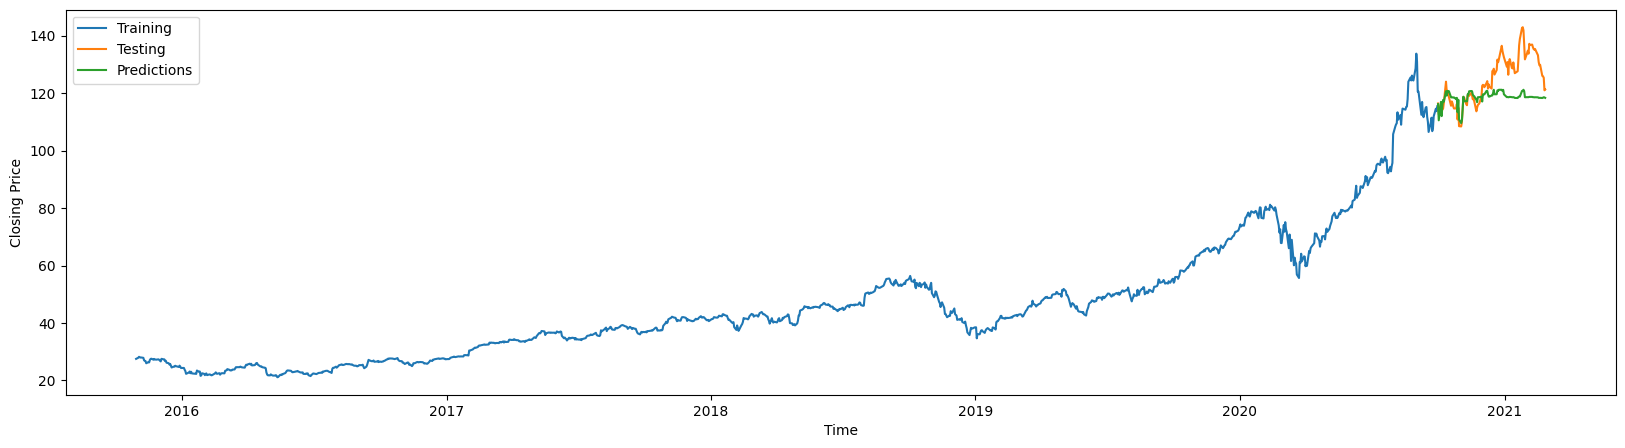

In [5]:
split_date = '2020-10-01'

# Data preparation
aapl_x_train, aapl_y_train, aapl_x_test, aapl_y_test = prep_data(AAPL, split_date)

# Train model
lgb_aapl_model, lgb_aapl_pred = lightgbm_model(aapl_x_train, aapl_y_train, aapl_x_test, aapl_y_test)
AAPL_prediction = lgb_aapl_pred
print("Shape of Prediction: ",AAPL_prediction.shape)

# Model performance
rmse = math.sqrt(mean_squared_error(aapl_y_test, lgb_aapl_pred))
mape = mean_absolute_percentage_error(aapl_y_test, lgb_aapl_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < split_date], AAPL['Adj. Close'][AAPL['Date'] < split_date], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= split_date], AAPL['Adj. Close'][AAPL['Date'] >= split_date], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= split_date], AAPL_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [6]:
# # Get feature importance
# importance = lgb_aapl_model.feature_importance()

# # Get feature names
# feature_names = lgb_aapl_model.feature_name()

# # Combine them into a DataFrame for better readability
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': importance
# }).sort_values(by='Importance', ascending=False)

# top_n = 20
# print(importance_df.head(top_n))

# # Display the top features
# # print(importance_df)

# Tesla

### Model Fitting & Prediction

/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_k'] = ((data['Adj. Close'] - lowest_low) / (highest_high - lowest_low)) * 100
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_d'] = data['stoch_k'].rolling(3).mean()
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:68: PerformanceWarning: DataFrame is highly fragmented.

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24466]	training's rmse: 0.000969966	valid_1's rmse: 228.574
RMSE: 228.57387787126493
MAPE: 0.22622114764348922


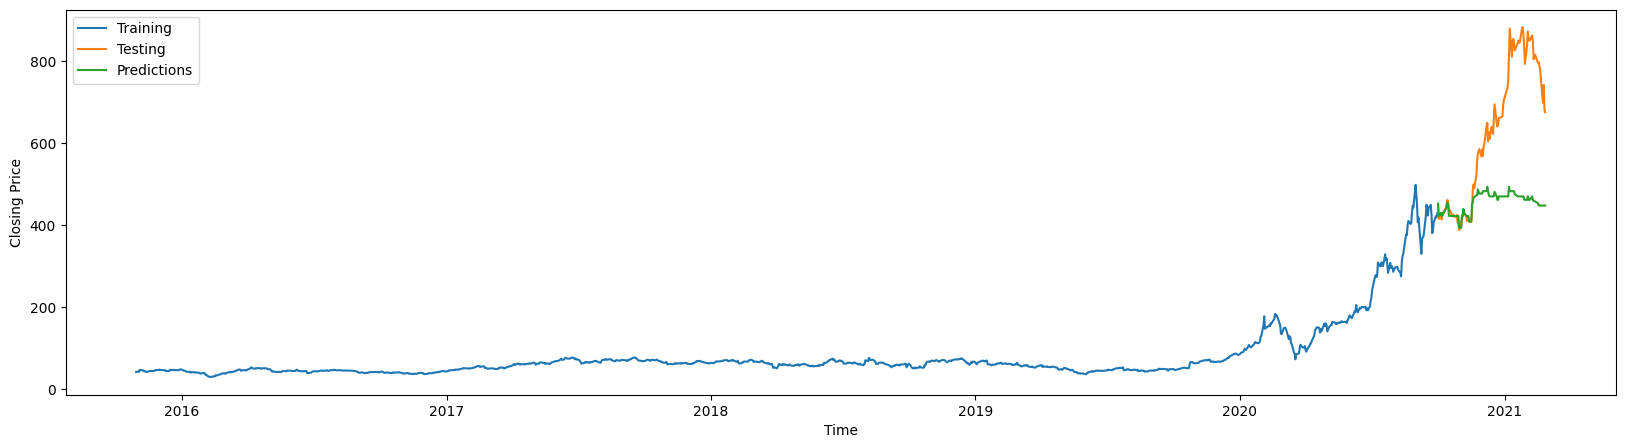

In [7]:
split_date = '2020-10-01'

# Data preparation
tsla_x_train, tsla_y_train, tsla_x_test, tsla_y_test = prep_data(TSLA, split_date)

# Train model
lgb_tsla_model, lgb_tsla_pred = lightgbm_model(tsla_x_train, tsla_y_train, tsla_x_test, tsla_y_test)
TSLA_prediction = lgb_tsla_pred

# Model performance
rmse = math.sqrt(mean_squared_error(tsla_y_test, lgb_tsla_pred))
mape = mean_absolute_percentage_error(tsla_y_test, lgb_tsla_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

plt.figure(figsize=(20, 5))
plt.plot(TSLA['Date'][TSLA['Date'] < split_date], TSLA['Adj. Close'][TSLA['Date'] < split_date], label = 'Training')
plt.plot(TSLA['Date'][TSLA['Date'] >= split_date], TSLA['Adj. Close'][TSLA['Date'] >= split_date], label = 'Testing')
plt.plot(TSLA['Date'][TSLA['Date'] >= split_date], TSLA_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

# Google

### Model Fitting & Prediction

Training until validation scores don't improve for 200 rounds


/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_k'] = ((data['Adj. Close'] - lowest_low) / (highest_high - lowest_low)) * 100
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_d'] = data['stoch_k'].rolling(3).mean()
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:68: PerformanceWarning: DataFrame is highly fragmented.

Early stopping, best iteration is:
[47257]	training's rmse: 6.15839e-05	valid_1's rmse: 198.515
RMSE: 198.51511407757081
MAPE: 0.08357568734837845


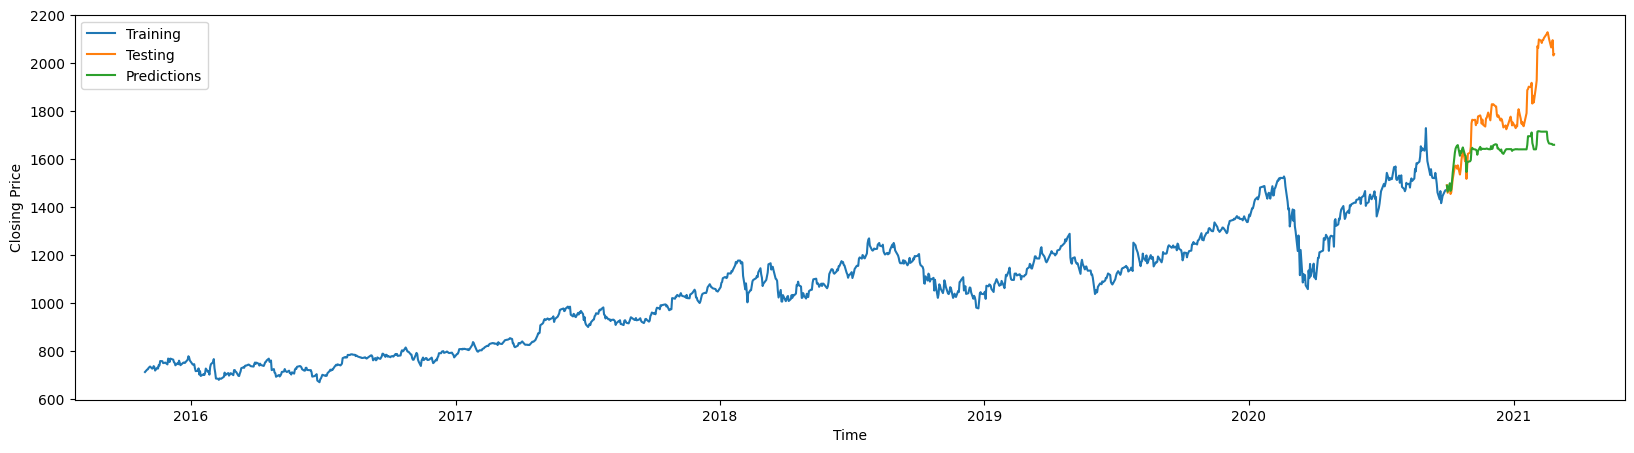

In [8]:
split_date = '2020-10-01'

# Data preparation
goog_x_train, goog_y_train, goog_x_test, goog_y_test = prep_data(GOOG, split_date)

# Train model
lgb_goog_model, lgb_goog_pred = lightgbm_model(goog_x_train, goog_y_train, goog_x_test, goog_y_test)
GOOG_prediction = lgb_goog_pred

# Model performance
rmse = math.sqrt(mean_squared_error(goog_y_test, lgb_goog_pred))
mape = mean_absolute_percentage_error(goog_y_test, lgb_goog_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

plt.figure(figsize=(20, 5))
plt.plot(GOOG['Date'][GOOG['Date'] < split_date], GOOG['Adj. Close'][GOOG['Date'] < split_date], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= split_date], GOOG['Adj. Close'][GOOG['Date'] >= split_date], label = 'Testing')
plt.plot(GOOG['Date'][GOOG['Date'] >= split_date], GOOG_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

# Microsoft

### Model Fitting & Prediction

Training until validation scores don't improve for 200 rounds


/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_k'] = ((data['Adj. Close'] - lowest_low) / (highest_high - lowest_low)) * 100
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_d'] = data['stoch_k'].rolling(3).mean()
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:68: PerformanceWarning: DataFrame is highly fragmented.

Early stopping, best iteration is:
[33142]	training's rmse: 7.20272e-05	valid_1's rmse: 8.91304
RMSE: 8.91304201032613
MAPE: 0.028004620789752254


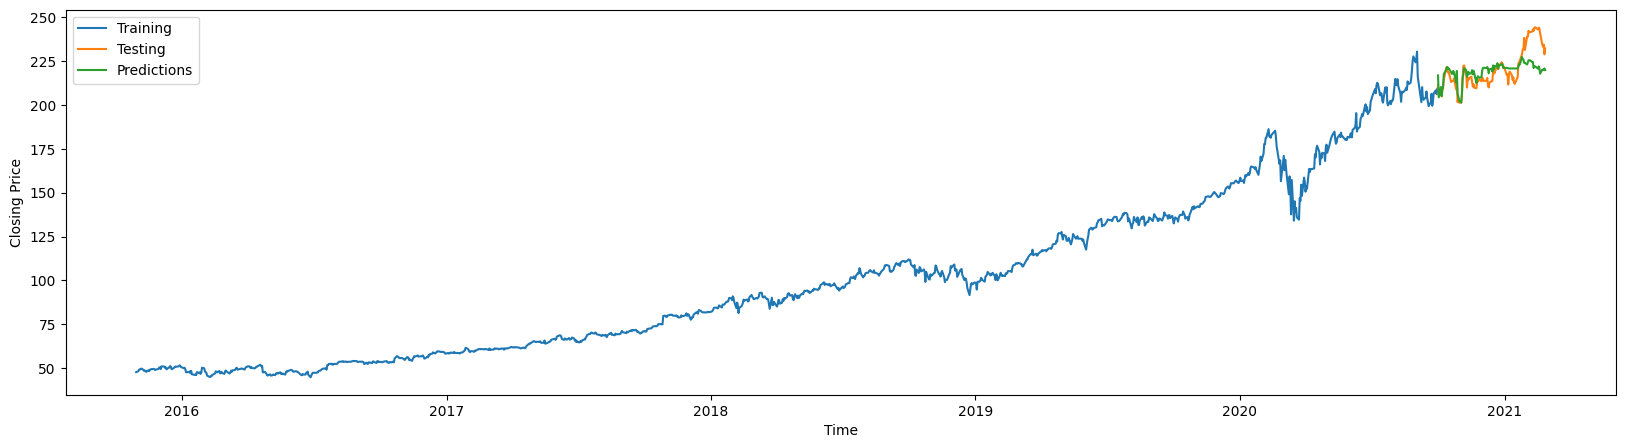

In [9]:
split_date = '2020-10-01'

# Data preparation
msft_x_train, msft_y_train, msft_x_test, msft_y_test = prep_data(MSFT, split_date)

# Train model
lgb_msft_model, lgb_msft_pred = lightgbm_model(msft_x_train, msft_y_train, msft_x_test, msft_y_test)
MSFT_prediction = lgb_msft_pred

# Model performance
rmse = math.sqrt(mean_squared_error(msft_y_test, lgb_msft_pred))
mape = mean_absolute_percentage_error(msft_y_test, lgb_msft_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

plt.figure(figsize=(20, 5))
plt.plot(MSFT['Date'][MSFT['Date'] < split_date], MSFT['Adj. Close'][MSFT['Date'] < split_date], label = 'Training')
plt.plot(MSFT['Date'][MSFT['Date'] >= split_date], MSFT['Adj. Close'][MSFT['Date'] >= split_date], label = 'Testing')
plt.plot(MSFT['Date'][MSFT['Date'] >= split_date], MSFT_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

# Amazon

### Model Fitting & Prediction

Training until validation scores don't improve for 200 rounds


/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_k'] = ((data['Adj. Close'] - lowest_low) / (highest_high - lowest_low)) * 100
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['stoch_d'] = data['stoch_k'].rolling(3).mean()
/var/folders/_f/3q5fpvj92n1ftxftqk1sg3f80000gn/T/ipykernel_42254/1893823153.py:68: PerformanceWarning: DataFrame is highly fragmented.

Early stopping, best iteration is:
[356]	training's rmse: 20.7729	valid_1's rmse: 43.3999
RMSE: 43.39986684521893
MAPE: 0.010361412115723776


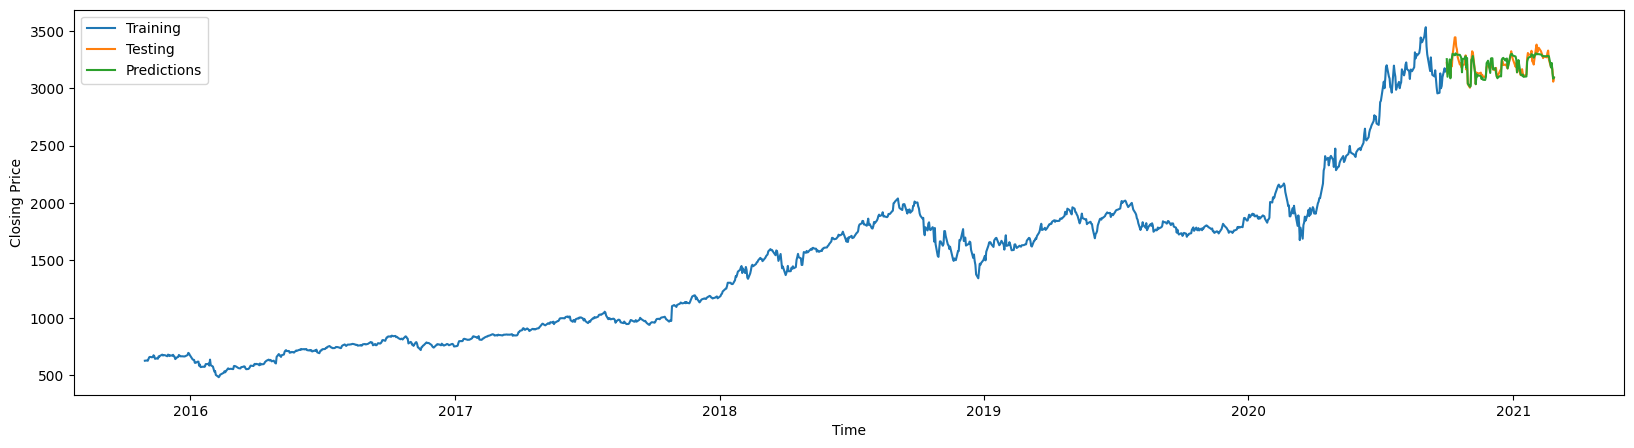

In [10]:
split_date = '2020-10-01'

# Data preparation
amzn_x_train, amzn_y_train, amzn_x_test, amzn_y_test = prep_data(AMZN, split_date)

# Train model
lgb_amzn_model, lgb_amzn_pred = lightgbm_model(amzn_x_train, amzn_y_train, amzn_x_test, amzn_y_test)
AMZN_prediction = lgb_amzn_pred

# Model performance
rmse = math.sqrt(mean_squared_error(amzn_y_test, lgb_amzn_pred))
mape = mean_absolute_percentage_error(amzn_y_test, lgb_amzn_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

plt.figure(figsize=(20, 5))
plt.plot(AMZN['Date'][AMZN['Date'] < split_date], AMZN['Adj. Close'][AMZN['Date'] < split_date], label = 'Training')
plt.plot(AMZN['Date'][AMZN['Date'] >= split_date], AMZN['Adj. Close'][AMZN['Date'] >= split_date], label = 'Testing')
plt.plot(AMZN['Date'][AMZN['Date'] >= split_date], AMZN_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')